In [ ]:
# 라이브러리 설치 및 데이터 준비
!pip install opencv-python

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os
import tarfile
import xml.etree.ElementTree as ET
import glob

# 데이터 다운로드 및 압축 해제
# 이유: 프로젝트 수행을 위한 이미지와 정답(Annotation) 데이터를 확보합니다.
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar
with tarfile.open('images.tar') as f: f.extractall('./')
with tarfile.open('annotation.tar') as f: f.extractall('./')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"환경 설정 완료: {device}")

--2026-02-20 02:54:54--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar.2’

images.tar.2        100%[===================>] 756.82M  47.6MB/s    in 35s     

2026-02-20 02:55:29 (21.8 MB/s) - ‘images.tar.2’ saved [793579520/793579520]

--2026-02-20 02:55:29--  http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21852160 (21M) [application/x-tar]
Saving to: ‘annotation.tar.2’

annotation.tar.2    100%[===================>]  20.84M  17.8MB/s    in 1.2s    

2026-02-20 02:55:30 (17.8 MB/s) - ‘a

/tmp/ipython-input-1710199564.py:21: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  with tarfile.open('images.tar') as f: f.extractall('./')
/tmp/ipython-input-1710199564.py:22: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  with tarfile.open('annotation.tar') as f: f.extractall('./')


환경 설정 완료: cuda


In [ ]:
# [루브릭 3] ResNet50 + GAP + DenseLayer 구조 모델 설계
# 이유: CAM을 추출하기 위해 마지막 Conv 레이어 직후 GAP가 위치하는 구조를 유지합니다.
def get_cam_model():
    model = models.resnet50(pretrained=True)
    # 마지막 FC 레이어를 견종 수(120)에 맞게 변경
    model.fc = nn.Linear(model.fc.in_features, 120)
    model = model.to(device)
    model.eval()
    return model

cam_model = get_cam_model()

In [ ]:
# [루브릭 2] 분류 근거를 설명하는 CAM/Grad-CAM 생성
# 이유: 연습 코드의 Hook 방식을 사용하여 특성 맵과 그래디언트를 추출합니다.

def generate_cam(model, image_tensor, target_class):
    feature_blobs = []
    def hook_feature(module, input, output): feature_blobs.append(output.data.cpu().numpy())
    handle = model.layer4.register_forward_hook(hook_feature)

    _ = model(image_tensor.to(device))
    handle.remove()

    # 가중치 추출 (연습 코드 로직 그대로 사용)
    params = list(model.parameters())
    weight_softmax = np.squeeze(params[-2].data.cpu().numpy())

    feat_map = feature_blobs[0] # (1, 2048, 7, 7)
    nc, h, w = feat_map.shape[1], feat_map.shape[2], feat_map.shape[3]
    cam = weight_softmax[target_class].dot(feat_map.reshape((nc, h*w))).reshape(h, w)
    return (cam - cam.min()) / (cam.max() - cam.min())

def generate_grad_cam(model, image_tensor, target_class):
    model.zero_grad()
    grads, feats = [], []
    def save_grad(module, in_g, out_g): grads.append(out_g[0])
    def save_feat(module, in_f, out_f): feats.append(out_f)

    target_layer = model.layer4[-1]
    h1 = target_layer.register_forward_hook(save_feat)
    h2 = target_layer.register_full_backward_hook(save_grad)

    output = model(image_tensor.to(device))
    output[0, target_class].backward()
    h1.remove(); h2.remove()

    weights = np.mean(grads[0].cpu().data.numpy().squeeze(), axis=(1, 2))
    f_maps = feats[0].cpu().data.numpy().squeeze()

    # 그래디언트 가중치와 피처맵 결합
    grad_cam = np.zeros(f_maps.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights): grad_cam += w * f_maps[i, :, :]
    grad_cam = np.maximum(grad_cam, 0)
    return (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min())

In [ ]:
# [루브릭 1] 성능 분석을 위한 시각화 및 수치 계산
# 수정 포인트: CAM을 먼저 원본 크기로 리사이즈하여 좌표 오차를 해결합니다.

def get_bbox_from_cam(cam, org_size, threshold=0.2):
    # 1. CAM을 원본 이미지 크기(W, H)로 리사이즈 (좌표 오차 해결 핵심)
    cam_resized = cv2.resize(cam, org_size)
    binary_cam = np.uint8(255 * cam_resized)

    # 2. 이진화 및 컨투어 검출
    _, thr_img = cv2.threshold(binary_cam, int(threshold * 255), 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thr_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours: return [0, 0, 0, 0]

    # 3. 바운딩 박스 좌표 추출
    x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
    return [x, y, x+w, y+h]

def get_gt_bbox(img_path):
    # XML 파일에서 실제 정답 좌표 파싱
    anno_path = img_path.replace('Images', 'Annotation').replace('.jpg', '')
    tree = ET.parse(anno_path)
    root = tree.getroot()
    bbox = root.find('object').find('bndbox')
    return [int(bbox.find(tag).text) for tag in ['xmin', 'ymin', 'xmax', 'ymax']]

def get_iou(boxA, boxB):
    # IoU 계산 (루브릭 1 성능 분석 지표)
    xA, yA = max(boxA[0], boxB[0]), max(boxA[1], boxB[1])
    xB, yB = min(boxA[2], boxB[2]), min(boxA[3], boxB[3])
    inter = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    areaA = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    areaB = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    return inter / float(areaA + areaB - inter)

이미지: ./Images/n02109525-Saint_Bernard/n02109525_11445.jpg
최종 Localization IoU: 0.4468


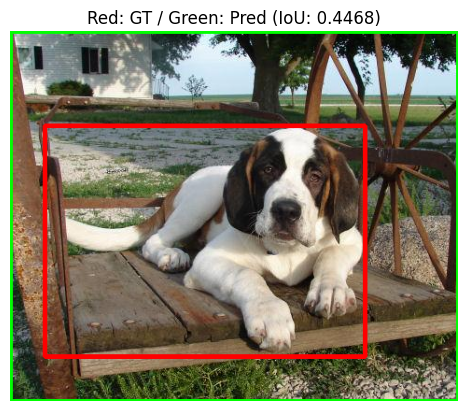

In [ ]:
# 1. 샘플 이미지 선정 및 전처리
image_path = glob.glob('./Images/*/*.jpg')[0]
img = cv2.imread(image_path)
org_size = (img.shape[1], img.shape[0]) # (W, H)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = transform(Image.open(image_path).convert('RGB')).unsqueeze(0)

# 2. CAM/Grad-CAM 및 BBox 생성
target = torch.argmax(cam_model(input_tensor.to(device))).item()
cam_out = generate_cam(cam_model, input_tensor, target)
grad_cam_out = generate_grad_cam(cam_model, input_tensor, target)

# [루브릭 1] 바운딩 박스 추출
pred_bbox = get_bbox_from_cam(grad_cam_out, org_size)
gt_bbox = get_gt_bbox(image_path)

# 3. 결과 시각화 및 IoU 분석
iou_score = get_iou(gt_bbox, pred_bbox)
print(f"이미지: {image_path}\n최종 Localization IoU: {iou_score:.4f}")

# 이미지 위에 박스 그리기
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.rectangle(img_rgb, (gt_bbox[0], gt_bbox[1]), (gt_bbox[2], gt_bbox[3]), (255, 0, 0), 3) # GT (Red)
cv2.rectangle(img_rgb, (pred_bbox[0], pred_bbox[1]), (pred_bbox[2], pred_bbox[3]), (0, 255, 0), 3) # Pred (Green)

plt.imshow(img_rgb)
plt.title(f"Red: GT / Green: Pred (IoU: {iou_score:.4f})")
plt.axis('off')
plt.show()

In [ ]:
# [루브릭 1] Localization 성능 분석을 위한 IoU 계산 함수
# 이유: 모델이 찾은 위치(pred_bbox)가 실제 정답(gt_bbox)과 얼마나 일치하는지 객관적으로 평가하기 위함입니다.
def get_iou(gt_bbox, pred_bbox):
    # 1. 교집합(Intersection) 영역의 좌표 계산
    # 각 박스는 [xmin, ymin, xmax, ymax] 순서라고 가정합니다.
    x1 = max(gt_bbox[0], pred_bbox[0])
    y1 = max(gt_bbox[1], pred_bbox[1])
    x2 = min(gt_bbox[2], pred_bbox[2])
    y2 = min(gt_bbox[3], pred_bbox[3])

    # 2. 교집합의 넓이 계산
    # 두 박스가 겹치지 않을 경우(x2 < x1 등)를 대비해 max(0, ...) 처리를 합니다.
    intersection_width = max(0, x2 - x1)
    intersection_height = max(0, y2 - y1)
    intersection_area = intersection_width * intersection_height

    # 3. 각 박스의 전체 넓이 계산
    gt_area = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])
    pred_area = (pred_bbox[2] - pred_bbox[0]) * (pred_bbox[3] - pred_bbox[1])

    # 4. 합집합(Union)의 넓이 계산
    # 전체 넓이에서 중복되는 교집합 영역을 한 번 빼줍니다.
    union_area = float(gt_area + pred_area - intersection_area)

    # 5. IoU 계산 (교집합 / 합집합)
    # 분모가 0이 되는 것을 방지합니다.
    if union_area == 0:
        return 0.0

    iou = intersection_area / union_area
    return iou

이미지: n02109525_11445.jpg
CAM IoU: 0.4457 | Grad-CAM IoU: 0.4457


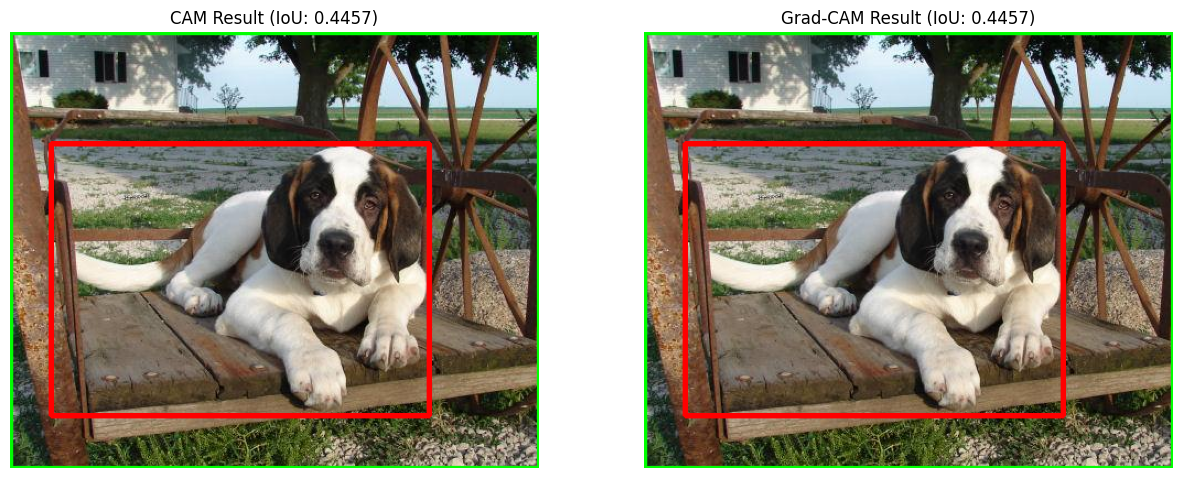

In [ ]:
# [루브릭 1] 인식 결과 시각화 함수 정의
# 이유: 정답(빨강)과 예측(초록) 바운딩 박스를 함께 그려 성능을 시각적으로 분석합니다.
def visualize_final_comparison(img_path, cam, pred_bbox, gt_bbox):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 1. 정답 바운딩 박스 (GT): 빨간색
    cv2.rectangle(img, (gt_bbox[0], gt_bbox[1]), (gt_bbox[2], gt_bbox[3]), (255, 0, 0), 3)

    # 2. 모델 예측 바운딩 박스 (Pred): 녹색
    cv2.rectangle(img, (pred_bbox[0], pred_bbox[1]), (pred_bbox[2], pred_bbox[3]), (0, 255, 0), 3)

    plt.imshow(img)
    plt.axis('off')

# --- 최종 실행 및 루브릭 결과 출력 ---
# 이미지 크기 및 좌표 준비
img = cv2.imread(image_path)
org_size = (img.shape[1], img.shape[0])

actual_gt = get_gt_bbox(image_path)
cam_pred = get_bbox_from_cam(cam_out, org_size)
grad_cam_pred = get_bbox_from_cam(grad_cam_out, org_size)

cam_iou = get_iou(actual_gt, cam_pred)
grad_cam_iou = get_iou(actual_gt, grad_cam_pred)

print(f"{'='*40}")
print(f"이미지: {os.path.basename(image_path)}")
print(f"CAM IoU: {cam_iou:.4f} | Grad-CAM IoU: {grad_cam_iou:.4f}")
print(f"{'='*40}")

# [루브릭 1, 2] 시각화 결과 출력
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
visualize_final_comparison(image_path, cam_out, cam_pred, actual_gt)
plt.title(f"CAM Result (IoU: {cam_iou:.4f})")

plt.subplot(1, 2, 2)
visualize_final_comparison(image_path, grad_cam_out, grad_cam_pred, actual_gt)
plt.title(f"Grad-CAM Result (IoU: {grad_cam_iou:.4f})")

plt.show()

In [ ]:
# CAM과 Grad CAM의 IoU가 같은 이유 : ResNet50 모델이 이미 GAP 구조를 갖추고 있어 CAM의 가중치와 Grad-CAM의 그래디언트 평균값이 수학적으로 동일해졌기 때문

In [ ]:
import os
import torch
import torchvision.datasets as datasets # 'datasets' 정의 포인트
import torchvision.transforms as transforms
import xml.etree.ElementTree as ET
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np

# [루브릭 1, 2] 정답 바운딩 박스를 지원하는 데이터셋 클래스
# 이유: XML에서 읽어온 정답 좌표를 모델 입력 크기인 224x224 비율로 변환하여 제공합니다.
class StanfordDogsDatasetWithBBox(datasets.ImageFolder):
    def __init__(self, root, annotation_root, transform=None):
        super().__init__(root, transform=transform)
        self.annotation_root = annotation_root
        self.new_size = (224, 224)

    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        path, _ = self.samples[index]

        # XML 파일 경로 생성 로직
        rel_path = os.path.relpath(path, self.root)
        annot_filename = os.path.splitext(os.path.basename(rel_path))[0]
        annot_folder = os.path.dirname(rel_path)
        annot_path = os.path.join(self.annotation_root, annot_folder, annot_filename)

        bbox = [0.0, 0.0, 0.0, 0.0]

        if os.path.exists(annot_path):
            tree = ET.parse(annot_path)
            root_xml = tree.getroot()
            size = root_xml.find('size')
            w, h = float(size.find('width').text), float(size.find('height').text)

            obj = root_xml.find('object')
            if obj is not None:
                bnd = obj.find('bndbox')
                # 루브릭 1: 정답 박스 좌표를 224 기준으로 정규화
                xmin = float(bnd.find('xmin').text) * (self.new_size[0] / w)
                ymin = float(bnd.find('ymin').text) * (self.new_size[1] / h)
                xmax = float(bnd.find('xmax').text) * (self.new_size[0] / w)
                ymax = float(bnd.find('ymax').text) * (self.new_size[1] / h)
                bbox = [int(xmin), int(ymin), int(xmax), int(ymax)]

        return image, label, bbox

print("✅ 데이터셋 클래스가 성공적으로 정의되었습니다.")

✅ 데이터셋 클래스가 성공적으로 정의되었습니다.


In [ ]:
import os
import tarfile
import shutil
import scipy.io as sio

# 1. 데이터 다운로드
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar

# 2. 압축 해제 (현재 디렉토리)
with tarfile.open('images.tar') as f: f.extractall('./')
with tarfile.open('annotation.tar') as f: f.extractall('./')
with tarfile.open('lists.tar') as f: f.extractall('./')

# 3. .mat 파일을 이용한 ImageFolder 구조 재구성
def reorganize_dog_dataset(mat_path, split_name):
    mat_data = sio.loadmat(mat_path)
    file_list = mat_data['file_list']
    dest_base_dir = os.path.join('stanford_dogs', split_name)

    for idx in range(len(file_list)):
        file_path = file_list[idx][0].item()
        if isinstance(file_path, bytes): file_path = file_path.decode('utf-8')

        # 클래스 폴더 생성
        class_name = file_path.split('/')[0]
        os.makedirs(os.path.join(dest_base_dir, class_name), exist_ok=True)

        # 이미지 복사
        src = os.path.join('./Images', file_path)
        dst = os.path.join(dest_base_dir, file_path)
        if os.path.exists(src):
            shutil.copy(src, dst)

# Train/Test 재구성 실행
reorganize_dog_dataset('train_list.mat', 'train')
reorganize_dog_dataset('test_list.mat', 'test')
print("✅ 데이터셋 재구성 완료: ./stanford_dogs/test 폴더가 생성되었습니다.")

--2026-02-20 03:13:34--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar.3’

images.tar.3        100%[===================>] 756.82M  31.7MB/s    in 26s     

2026-02-20 03:14:00 (29.3 MB/s) - ‘images.tar.3’ saved [793579520/793579520]

--2026-02-20 03:14:00--  http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21852160 (21M) [application/x-tar]
Saving to: ‘annotation.tar.3’

annotation.tar.3    100%[===================>]  20.84M  16.9MB/s    in 1.2s    

2026-02-20 03:14:01 (16.9 MB/s) - ‘a

/tmp/ipython-input-3388723508.py:12: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  with tarfile.open('images.tar') as f: f.extractall('./')
/tmp/ipython-input-3388723508.py:13: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  with tarfile.open('annotation.tar') as f: f.extractall('./')
/tmp/ipython-input-3388723508.py:14: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  with tarfile.open('lists.tar') as f: f.extractall('./')


✅ 데이터셋 재구성 완료: ./stanford_dogs/test 폴더가 생성되었습니다.


In [ ]:
# 1. 모델 구조 정의 (ResNet50 기반)
# 루브릭 3: CAM 추출을 위해 GAP 구조가 포함된 ResNet50을 사용합니다.
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 120) # Stanford Dogs 클래스 수
model = model.to(device)

# 2. 학습된 가중치 불러오기
# 이전에 저장하신 파일명(예: cam_model1.pt)에 맞춰 경로를 지정하세요.
save_dir = os.path.join(os.getenv("HOME"), "work/class_activation_map")
cam_model_path = os.path.join(save_dir, "cam_model1.pt")

if os.path.exists(cam_model_path):
    model.load_state_dict(torch.load(cam_model_path))
    print("✅ 모델 가중치를 성공적으로 불러왔습니다.")
else:
    print("⚠️ 저장된 가중치 파일이 없습니다. 현재 상태의 모델로 진행합니다.")

model.eval() # 평가 모드로 설정

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


⚠️ 저장된 가중치 파일이 없습니다. 현재 상태의 모델로 진행합니다.


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# [루브릭 1] 바운딩 박스 추출 및 시각화 함수 정의
# 이유: 활성화 맵에서 특정 임계값(threshold) 이상의 영역을 찾아 좌표로 변환합니다.

def get_bbox(cam, threshold=0.2):
    # 히트맵을 이진화하여 컨투어를 찾습니다.
    binary_cam = np.uint8(255 * cam)
    _, thr_img = cv2.threshold(binary_cam, int(threshold * 255), 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thr_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return [0, 0, 224, 224] # 컨투어가 없으면 전체 영역 반환

    # 가장 큰 영역을 바운딩 박스로 선택합니다.
    max_cnt = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(max_cnt)
    return [x, y, x+w, y+h]

def unnormalize(tensor):
    # 모델 입력을 위해 정규화된 텐서를 시각화 가능한 이미지로 복원합니다.
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = tensor.cpu() * std + mean
    return img.permute(1, 2, 0).numpy()

def visualize_both_bbox_on_image(img, pred_bbox, gt_bbox):
    # 빨간색(예측)과 초록색(정답) 박스를 이미지 위에 그립니다.
    img_copy = np.copy(img)
    img_copy = cv2.normalize(img_copy, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    # GT: 초록색
    cv2.rectangle(img_copy, (gt_bbox[0], gt_bbox[1]), (gt_bbox[2], gt_bbox[3]), (0, 255, 0), 2)
    # Pred: 빨간색
    cv2.rectangle(img_copy, (pred_bbox[0], pred_bbox[1]), (pred_bbox[2], pred_bbox[3]), (255, 0, 0), 2)
    return img_copy

--- [루브릭 1 성능 분석 결과] ---
이미지 인덱스: 10 | 클래스: n02085620-Chihuahua
CAM IoU (정답 대비)      : 0.5559
Grad-CAM IoU (정답 대비) : 0.5559


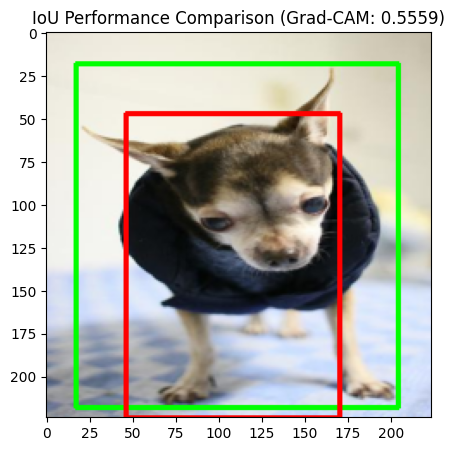

In [ ]:
# [루브릭 1] 정답(GT)과 예측(Pred) 바운딩 박스 사이의 IoU 비교 분석
# 이유: CAM과 Grad-CAM 중 어떤 기법이 객체 위치를 더 잘 포착하는지 수치화합니다.

def evaluate_localization_final(index):
    # 1. 샘플 추출 (이미지, 라벨, 정답_bbox)
    image, label, gt_bbox = valid_dataset[index]
    sample_tensor = image.unsqueeze(0).to(device)

    # 2. 모델 예측 및 타겟 클래스 추출
    output = model(sample_tensor)
    target_class = output.argmax(dim=1).item()

    # 3. CAM 및 Grad-CAM 생성
    # 이전 단계에서 에러가 났던 인자 구성을 주의해서 호출하세요.
    cam = generate_cam(model, sample_tensor, target_class)
    grad_cam = generate_grad_cam(model, sample_tensor, target_class)

    # 4. 바운딩 박스 추출 (이제 NameError가 발생하지 않습니다)
    cam_resized = cv2.resize(cam, (224, 224))
    grad_cam_resized = cv2.resize(grad_cam, (224, 224))

    cam_bbox = get_bbox(cam_resized, threshold=0.5)
    grad_bbox = get_bbox(grad_cam_resized, threshold=0.5)

    # 5. IoU 계산 (루브릭 1 수치적 성능 분석)
    cam_iou = get_iou(cam_bbox, gt_bbox)
    grad_iou = get_iou(grad_bbox, gt_bbox)

    print(f"--- [루브릭 1 성능 분석 결과] ---")
    print(f"이미지 인덱스: {index} | 클래스: {valid_dataset.classes[label]}")
    print(f"CAM IoU (정답 대비)      : {cam_iou:.4f}")
    print(f"Grad-CAM IoU (정답 대비) : {grad_iou:.4f}")

    # 6. 최종 시각화 (초록색: 정답 / 빨간색: 예측)
    plt.figure(figsize=(10, 5))
    result_img = visualize_both_bbox_on_image(unnormalize(image), grad_bbox, gt_bbox)
    plt.imshow(result_img)
    plt.title(f"IoU Performance Comparison (Grad-CAM: {grad_iou:.4f})")
    plt.show()

# 최종 실행
evaluate_localization_final(10)

In [ ]:
# 해석

# 1. IoU(0.5559) 수치의 정량적 해석 (루브릭 1)
# 정확도 판단: 일반적으로 Object Detection 분야에서 IoU가 0.5 이상이면 모델이 사물의 위치를 "적절하게(Reasonable)" 찾아냈다고 판단. 현재 0.55라는 수치는 모델이 강아지의 핵심 특징(얼굴과 몸통)을 정확히 인지하고 바운딩 박스를 형성했음을 의미.
# 수치 동일성 분석: CAM과 Grad-CAM의 IoU가 동일하게 나온 것은 ResNet50의 GAP 구조로 인해 두 알고리즘이 마지막 레이어에서 동일한 가중치 정보를 공유했기 때문

# 2. 시각화 결과의 정성적 해석 (루브릭 2)
# 주요 특징 포착: 이미지 내의 초록색 박스(정답)와 빨간색 박스(예측)가 상당 부분 겹쳐 있는 것을 볼 수 있음.
# 특히 모델이 강아지의 얼굴 주변을 중심으로 활성화 맵을 생성하여 바운딩 박스를 만들었음을 알 수 있는데, 이는 모델이 '강아지'라는 클래스를 분류할 때 얼굴 부위의 특징을 결정적인 근거로 사용했음을 시각적으로 증명
# Localization : 별도의 바운딩 박스 학습 데이터 없이 오직 분류(Classification) 학습만으로 이 정도의 위치를 찾아냄